# Notebook to test SetFit performance

Check CUDA

In [1]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Load dataset and transform data

In [2]:
import pandas as pd
import numpy as np

dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')

In [3]:
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset = subset[['text','label']]
subset_label_transform = subset.copy() # to test with different

subset_label_transform['label'] = np.where((subset_label_transform["label"] < 3) | (subset_label_transform["label"].isna()), 0, 1)
subset_label_transform

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


Split the dataset in two: training and test set

In [4]:
from datasets import Dataset, disable_progress_bar
disable_progress_bar() # Disable "Map" progress bar in the tests

def split_train_test(dataset, ratio):
    test_set = dataset.sample(frac = ratio, random_state=42)
    train_set = dataset.drop(test_set.index)
    return train_set, test_set

train_set, test_set = split_train_test(subset_label_transform, 0.2)

Create another train set and data set with different initial label values selected (0,1 and 3 and 4 only) and (0,4 only)

In [5]:
subset_label_transform_likely_labels = subset.copy()
subset_label_transform_likely_labels.replace({2: np.nan}, inplace=True)
subset_label_transform_likely_labels.dropna(inplace=True)
subset_label_transform_likely_labels['label'] = np.where((subset_label_transform_likely_labels["label"] < 3), 0, 1)

subset_label_transform_sure_labels = subset.copy()
subset_label_transform_sure_labels.replace({1: np.nan, 2: np.nan, 3: np.nan}, inplace=True)
subset_label_transform_sure_labels.dropna(inplace=True)
subset_label_transform_sure_labels['label'] = np.where((subset_label_transform_sure_labels["label"] == 0), 0, 1)

# We keep the full test set
train_set_likely_labels, _ = split_train_test(subset_label_transform_likely_labels, 0.2) 
train_set_sure_labels, _ = split_train_test(subset_label_transform_sure_labels, 0.2)

# Functions to test different hyper parameters

In [6]:
import json
from datetime import datetime
import os
from sentence_transformers.losses import CosineSimilarityLoss, BatchAllTripletLoss, BatchHardTripletLossDistanceFunction
from transformers import PrinterCallback, ProgressCallback
from setfit import Trainer, TrainingArguments, sample_dataset, SetFitModel
import gc
import time


import logging
import warnings


def save_to_json(object, folder_path):
	# Create folder if it doesn't exist
	if not os.path.exists(folder_path):
		os.makedirs(folder_path)
	# Generate file name
	date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
	file_name = folder_path+'/'+str(date)+".json"

	# Create file and save data
	with open(file_name, 'w') as file:
		json.dump(object, file)

In [7]:
def get_transformer_model(model_name, use_differentiable_head=False):
    model = SetFitModel.from_pretrained(model_name, use_differentiable_head=use_differentiable_head)
    gc.collect()
    torch.cuda.empty_cache()
    
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset, distance_metric = None, classification_head = None, num_epochs = None, batch_size = None, head_learning_rate = None):
    if distance_metric is None:
        distance_metric = BatchHardTripletLossDistanceFunction.cosine_distance # default value for SetFit
    if classification_head is None:
        classification_head = BatchHardTripletLossDistanceFunction.cosine_distance # default value for SetFit
    
    # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
    if num_epochs is None:
        num_epochs = (1,16) 
    if batch_size is None:
        batch_size = (16,2)
    
    if head_learning_rate is None:
        head_learning_rate = 1e-2
    
    trainer_arguments = TrainingArguments(
        show_progress_bar=False,
        loss=loss,
        distance_metric=distance_metric,
        batch_size=batch_size,
        num_epochs=num_epochs,
		head_learning_rate=head_learning_rate,
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    
    # Disable some logs because there were too many messages during the tests
    trainer.pop_callback(PrinterCallback)
    trainer.pop_callback(ProgressCallback)
    
    return trainer

def setfit_f1_score(train_set, test_set, model_name, loss, distance_metric=None, classification_head=None, num_epochs = None, batch_size = None, head_learning_rate = None):
    if len(train_set) <= 1 or len(test_set) <= 1:
        raise Exception
    
    model = get_transformer_model(model_name, (not (num_epochs is None)) and num_epochs[1]>1)
    trainer = init_trainer(model, loss, train_set, test_set, distance_metric, classification_head, num_epochs, batch_size, head_learning_rate)
    
    start_time = time.time()
    trainer.train()
    run_time = time.time() - start_time
    
    metrics = trainer.evaluate()
    
    del model
    del trainer
    torch.cuda.empty_cache()
    
    return metrics['f1'], run_time

In [8]:
from langdetect import detect

def filter_lang(df, lang):
    indices = []
    for i in range(len(df)):
        try:
            l = detect(df.iloc[i]["text"])
            if l == lang:
                indices.append(i)
        except:""
    
    return df.iloc[indices]

def filter_dataset(data, min_text_length=None, max_text_length=None, lang=None):
    if min_text_length is None:
        if max_text_length is None:
            filtered_data = data
        else:
            filtered_data = data[data['text'].str.split().apply(len) <= max_text_length]
    else:
        if max_text_length is None:
            filtered_data = data[data['text'].str.split().apply(len) >= min_text_length]
        else:
            filtered_data = data[data['text'].str.split().apply(len).between(min_text_length, max_text_length)]
            
    if not (lang is None):
        filtered_data = filter_lang(filtered_data, lang)
           
    return filtered_data

In [9]:
# Disable some logs because there were too many messages during the tests
# logging.disable(logging.INFO)
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

### N-Shots

In [10]:
def n_shot_tests(params, train_set, test_set):
	n_values = params["n_shot"]
	n_iter = params["n_iter"]
	n_max_iter_per_shot = params["n_max_iter_per_shot"]
	model = params["model"]
	loss = params["loss"]
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None
    
	n_values_max = np.max(n_values)

	results = {}
	run_times = {}
	for n_shot in n_values:
		results[n_shot] = []
		run_times[n_shot] = []
	
	progress = 0
	progress_end = n_iter * ((len(n_values)-1)*n_max_iter_per_shot + 1)
 
	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for i in range(n_iter):
		# Use the same subset of the dataset for all of the tests in the following loop
		if not (input_length_range is None):
			new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
		else:
			new_train_set = train_set
		new_train_set = new_train_set.sample(frac = 1, random_state=i*47).groupby('label').head(n_values_max)
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_test_set = Dataset.from_pandas(test_set, split="test")

		for n_shot in n_values:
			try:
				n_iter_shot = n_max_iter_per_shot if n_shot < n_values_max else 1
				for i_shot in range(n_iter_shot):
					progress += 1
					print("Step:", progress, "/", progress_end)
     
					train_set_n_shot = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*n_shot + 3*i_shot, num_epochs=num_epochs, batch_size=batch_size)
					f1_score, run_time = setfit_f1_score(train_set_n_shot, new_test_set, model, loss)
					results[n_shot].append(f1_score)
					run_times[n_shot].append(run_time)
			except Exception as err:
				print(n_shot, "failed", str(err))
	return results, run_times

### Input length

In [11]:
def input_length_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	len_values = params["input_length_range"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None
    
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for i in range(len(len_values)):
		key = f"[{len_values[i][0]},{len_values[i][1]}]"
		results[key] = []
		run_times[key] = []

	progress = 0
	progress_end = n_iter * len(len_values)
 
	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for iter in range(n_iter):
		for i in range(len(len_values)):
			key = f"[{len_values[i][0]},{len_values[i][1]}]"
			try:
				progress += 1
				print("Step:", progress, "/", progress_end)
    
				new_train_set = filter_dataset(train_set, len_values[i][0], len_values[i][1])
				new_train_set = Dataset.from_pandas(new_train_set, split="train")
				new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	return results, run_times

### Distance

In [12]:
def distance_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
	distances = params["distance"]
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None

	results = {}
	run_times = {}
	for key in distances.keys():
		results[key] = []
		run_times[key] = []

	new_test_set = Dataset.from_pandas(test_set, split="test")
 
	progress = 0
	progress_end = n_iter * (len(distances))

	for i in range(n_iter):
		if not (input_length_range is None):
			new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
		else:
			new_train_set = train_set
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		
		for key in distances.keys():
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss, distances[key], num_epochs=num_epochs, batch_size=batch_size)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	return results, run_times

### Loss

In [13]:
def loss_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	losses = params["loss"]
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None
 
	results = {}
	run_times = {}
	for key in losses.keys():
		results[key] = []
		run_times[key] = []

	new_test_set = Dataset.from_pandas(test_set, split="test")
 
	progress = 0
	progress_end = n_iter * (len(losses))

	for i in range(n_iter):
		if not (input_length_range is None):
			new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
		else:
			new_train_set = train_set
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		
		for key in losses.keys():
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, losses[key], num_epochs=num_epochs, batch_size=batch_size)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	return results, run_times

### Language

In [14]:
def language_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
	languages = params["lang"]
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None
 
	results = {}
	run_times = {}

	for key in languages:
		results[key] = []
		run_times[key] = []
	results['all'] = []
	run_times['all'] = []
 
	progress = 0
	progress_end = n_iter * (len(languages) + 1)
 
	for i in range(n_iter):
		temp_train_set_panda = {}
		temp_test_set_panda = {}

		for key in languages:
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			temp_train_set_panda[key] = filter_dataset(train_set, lang=key)
			if not (input_length_range is None):
				temp_train_set_panda[key] = filter_dataset(temp_train_set_panda[key], input_length_range[0], input_length_range[1])
			temp_train_set = Dataset.from_pandas(temp_train_set_panda[key], split="train")
			temp_train_set = sample_dataset(temp_train_set, label_column="label", num_samples=n_shot, seed=47*i)
   
			temp_test_set_panda[key] = filter_dataset(test_set, lang=key)
			temp_test_set = Dataset.from_pandas(temp_test_set_panda[key], split="test")
			try:
				f1_score, run_time = setfit_f1_score(temp_train_set, temp_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
				del temp_train_set_panda[key]
				del temp_test_set_panda[key]
		
		all_temp_train_set = list(temp_train_set_panda.values())
		all_temp_test_set = list(temp_train_set_panda.values())
  
		if len(all_temp_train_set) == 0 or len(all_temp_test_set) == 0:
			progress += 1
			print("Step:", progress, "/", progress_end, "failed")
			continue

		all_train_set = pd.concat(all_temp_train_set)
		all_train_set = Dataset.from_pandas(all_train_set, split="test")
		all_train_set = sample_dataset(all_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		all_test_set = pd.concat(all_temp_test_set)
		all_test_set = Dataset.from_pandas(all_test_set, split="test")
  
		try:
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			f1_score, run_time = setfit_f1_score(all_train_set, all_test_set, model, loss)
			results['all'].append(f1_score)
			run_times['all'].append(run_time)
		except Exception as err:
			print('all', "failed", str(err))
	return results, run_times

### Sentence transformers

Test SetFit with different ST models

In [15]:
def model_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	loss = params["loss"]
	models = params["model"]
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None
 
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for key in models.keys():
		results[key] = []
		run_times[key] = []

	progress = 0
	progress_end = n_iter * len(models)
 
	for i in range(n_iter):
		# Use the same subset of the dataset for all of the tests in the following loop
		if not (input_length_range is None):
			new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
		else:
			new_train_set = train_set
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

		for key, full_model_name in models.items():
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, full_model_name, loss, num_epochs=num_epochs, batch_size=batch_size)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	return results, run_times

### Number of epochs

In [16]:
def num_epochs_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	loss = params["loss"]
	model = params["model"]
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
	num_epochs = params["num_epochs"]
	batch_size = params["batch_size"] if "batch_size" in params else None
 
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for epoch_tuple in num_epochs:
		key = f"({epoch_tuple[0]}, {epoch_tuple[1]})"
		results[key] = []
		run_times[key] = []

	progress = 0
	progress_end = n_iter * len(num_epochs)
 
	for i in range(n_iter):
		# Use the same subset of the dataset for all of the tests in the following loop
		if not (input_length_range is None):
			new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
		else:
			new_train_set = train_set
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

		for epoch_tuple in num_epochs:
			key = f"({epoch_tuple[0]}, {epoch_tuple[1]})"
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss, num_epochs=epoch_tuple, batch_size=batch_size)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	return results, run_times

### Data sampling

In [17]:
def constant_params_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	loss = params["loss"]
	model = params["model"]
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
 
	results = []
	run_times = []
	new_test_set = Dataset.from_pandas(test_set, split="test")
	progress = 0

	for i in range(n_iter):
		progress += 1
		print("Step:", progress, "/", n_iter)
		if not (input_length_range is None):
			new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
		else:
			new_train_set = train_set
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

		try:
			f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
			results.append(f1_score)
			run_times.append(run_time)
		except Exception as err:
				print(i, "failed", str(err))
	return {"all":results}, {"all":run_times}

### Data Augmentation

In [18]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
import random

nltk.download('wordnet')

def get_synonyms(word, lang):
    l = 'fra' if lang == 'fr' else 'eng'
    synonyms=[synset.lemma_names(l) for synset in wordnet.synsets(word, lang=l)]
    return synonyms

def replace_with_synonym(word, synonyms):
	if synonyms:
		syn = random.choice(synonyms)
		if type(syn) == type([]):
			syn = random.choice(syn)
	return word

def gen_text_with_synonym_replacement(text, lang, params=None):
	modification_ratio = 1
	if not (params is None) and "modification_rate" in params :
		if params["modification_rate"] < 0 or params["modification_rate"] > 1:
			raise Exception("Invalid modification_rate (expected a value between 0 and 1)")
		else:
			modification_ratio = params["modification_rate"]
		
	sentences = sent_tokenize(text)
	augmented_sentences = []

	opposite_modification_ratio = 1 - modification_ratio	
 
	for sentence in sentences:
		tokenized = word_tokenize(sentence)
		augmented_tokens = []
		for token in tokenized:
			do_replace_by_synonym = 1 == np.random.choice([0,1], p=[opposite_modification_ratio,modification_ratio])
			if do_replace_by_synonym:
				synonyms = get_synonyms(token, lang)
				augmented_tokens.append(replace_with_synonym(token, synonyms))
			else:
				augmented_tokens.append(token)
		augmented_sentence = ' '.join(augmented_tokens)
		augmented_sentences.append(augmented_sentence)
	 
	augmented_text = ' '.join(augmented_sentences)
	return augmented_text

def augment_synonym_replacement(data, new_samples, n_new_samples_per_class, classes, strategy_params):
	progress = 0
	progress_end = n_new_samples_per_class * len(classes)
	do_continue = True
	
	while(do_continue and progress < progress_end):     
		for i in range(len(data)):
			c = data.iloc[i]["label"]
			if(len(new_samples[c]) >= n_new_samples_per_class):
				continue
				
			print("Data augmentation... (", progress, "/", progress_end,")")
			try:
				l = detect(data.iloc[i]["text"])
				if l != 'fr' and l != 'en':
					continue
				new_samples[c].append(gen_text_with_synonym_replacement(data.iloc[i]["text"], l, strategy_params))
			except Exception as err:
				print("failed", str(err))
	
			progress += 1
			if progress >= progress_end:
				break

		do_continue = False
		for val in new_samples.values():
			if len(val) < n_new_samples_per_class:
				do_continue = True
	
	return new_samples

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
from random import randint

def gen_text_from_sentences(sentences, length):
	selected_sentences = []
	for _ in range(length):
		selected_sentences.append(random.choice(sentences))
	return ' '.join(selected_sentences)
     

def augment_swapping_inter(data, new_samples, n_new_samples_per_class, classes):
	progress = 0
	progress_end = n_new_samples_per_class * len(classes)
	max_text_size = 10 # max number of sentences
 
	for c in classes:
		filtered_rows = data[data['label'] == c]
		sentences = []
		for i in range(len(filtered_rows)):
			sentences = sentences + sent_tokenize(filtered_rows.iloc[i]["text"])

		while(len(new_samples[c]) < n_new_samples_per_class):
			progress += 1
			print("Data augmentation... (", progress, "/", progress_end,")")
   
			length = randint(1, max(1,min(len(sentences)//4, max_text_size)))
			new_text = gen_text_from_sentences(sentences, length)
			new_samples[c].append(new_text)
				
	return new_samples

In [20]:
from math import floor

def augment_crossover(data, new_samples, n_new_samples_per_class, classes, strategy_params=None):
	n_points_crossover = floor(strategy_params["n_points_crossover"]) if not (strategy_params is None) and "n_points_crossover" in strategy_params else 1
	if n_points_crossover<0:
		n_points_crossover = 1
	progress = 0
	progress_end = n_new_samples_per_class * len(classes)
	n_divs = n_points_crossover+1
 
	for c in classes:
		filtered_rows = data[data['label'] == c]
		
		while(len(new_samples[c]) < n_new_samples_per_class):
			for parent1 in range(len(filtered_rows)):
				progress += 1
				print("Data augmentation... (", progress, "/", progress_end,")")
    
				parent2 =  random.choice([j for j in range(len(filtered_rows)) if j != parent1])
    
				sentences_parent1 = sent_tokenize(filtered_rows.iloc[parent1]["text"])
				sentences_parent2 = sent_tokenize(filtered_rows.iloc[parent2]["text"])
			
				chunk_len_parent1 = len(sentences_parent1) // n_divs + (1 if len(sentences_parent1) % n_divs != 0 else 0)
				chunk_len_parent2 = len(sentences_parent2) // n_divs + (1 if len(sentences_parent2) % n_divs != 0 else 0)
				i1 = 0
				i2 = 0

				augmented_sentences = []

				for _ in range(n_divs):
					if i1>=len(sentences_parent1):
						while i1>=len(sentences_parent1) and i2 < len(sentences_parent2):
							augmented_sentences.append(sentences_parent2[i2])
							i2 += 1
						break
					elif i2>=len(sentences_parent2):
						while i2>=len(sentences_parent2) and i1 < len(sentences_parent1):
							augmented_sentences.append(sentences_parent1[i1])
							i1 += 1
						break
					else:
						i_parent = random.choice([1,2])
						if i_parent == 1:
							i_chunk = 0
							while i_chunk < chunk_len_parent1 and i1<len(sentences_parent1):
								augmented_sentences.append(sentences_parent1[i1 + i_chunk])
								i_chunk += 1
							i1 += chunk_len_parent1
						else:
							i_chunk = 0
							while i_chunk < chunk_len_parent2 and i2<len(sentences_parent2):
								augmented_sentences.append(sentences_parent1[i2 + i_chunk])
								i_chunk += 1
							i1 += chunk_len_parent2
				

				new_text = ' '.join(augmented_sentences)
				new_samples[c].append(new_text)

				if len(new_samples[c]) >= n_new_samples_per_class:
					break
				
	return new_samples

In [21]:
from transformers import MarianMTModel, MarianTokenizer

def augment_back_translation(data, new_samples, n_new_samples_per_class, classes):
	model_name_fr_en = "Helsinki-NLP/opus-mt-fr-en"
	model_name_en_fr = "Helsinki-NLP/opus-mt-en-fr"

	tokenizer_fr_en = MarianTokenizer.from_pretrained(model_name_fr_en)
	tokenizer_en_fr = MarianTokenizer.from_pretrained(model_name_en_fr)
	model_fr_en = MarianMTModel.from_pretrained(model_name_fr_en)
	model_en_fr = MarianMTModel.from_pretrained(model_name_en_fr)	
	progress = 0
	progress_end = n_new_samples_per_class * len(classes)
	do_continue = True
 
	while(do_continue and progress < progress_end):     
		for i in range(len(data)):
			c = data.iloc[i]["label"]
			if(len(new_samples[c]) >= n_new_samples_per_class):
				continue
				
			print("Data augmentation... (", progress, "/", progress_end,")")
			try:
				l = detect(data.iloc[i]["text"])

				if l != 'fr' and l != 'en':
					continue

				if l == 'fr':
					temp = model_fr_en.generate(**tokenizer_fr_en(">>en<< "+data.iloc[i]["text"], return_tensors="pt", padding=True))[0]
					temp = tokenizer_fr_en.decode(temp, skip_special_tokens=True)
					temp = model_en_fr.generate(**tokenizer_en_fr(">>fr<< "+temp, return_tensors="pt", padding=True))[0]
					new_samples[c].append(tokenizer_en_fr.decode(temp, skip_special_tokens=True))
				elif l == 'en':
					temp = model_en_fr.generate(**tokenizer_en_fr(">>fr<< "+data.iloc[i]["text"], return_tensors="pt", padding=True))[0]
					temp = tokenizer_en_fr.decode(temp, skip_special_tokens=True)
					temp = model_fr_en.generate(**tokenizer_fr_en(">>en<< "+temp, return_tensors="pt", padding=True))[0]
					new_samples[c].append(tokenizer_fr_en.decode(temp, skip_special_tokens=True))
			except Exception as err:
				print("failed", str(err))
	
			progress += 1
			if progress >= progress_end:
				break

		do_continue = False
		for val in new_samples.values():
			if len(val) < n_new_samples_per_class:
				do_continue = True
    
	del tokenizer_fr_en
	del tokenizer_en_fr
	del model_fr_en
	del model_en_fr
 
	return new_samples

In [22]:
# Some methods come from: Li, Bohan, Yutai Hou, and Wanxiang Che. "Data augmentation approaches in natural language processing: A survey." Ai Open 3 (2022): 71-90.

def augment_data(data, n_new_samples_per_class, classes, strategy='synonym', strategy_params = None):
	if n_new_samples_per_class <= 0:
		return data

	new_samples = {}
	for c in classes:
		new_samples[c] = []

	if strategy == "swapping_inter":
		new_samples = augment_swapping_inter(data, new_samples, n_new_samples_per_class, classes)
	elif strategy == "back_translation":
		new_samples = augment_back_translation(data, new_samples, n_new_samples_per_class, classes)
	elif strategy == "synonym_replacement":
		new_samples = augment_synonym_replacement(data, new_samples, n_new_samples_per_class, classes, strategy_params)
	elif strategy == "crossover":
		new_samples = augment_crossover(data, new_samples, n_new_samples_per_class, classes, strategy_params)
	else:
		raise Exception("Unknown strategy")

	gc.collect()
	torch.cuda.empty_cache()

	newData = data.copy()
	for c, samples_list in new_samples.items():
		for sample in samples_list:
			newData.loc[len(newData.index)] = {"text":sample,"label":c}
	return newData

In [23]:
def data_augmentation_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
	input_length_range = params["input_length_range"] if "input_length_range" in params else None
	augmentation_ratios = params["data_augmentation_ratio"]
	strategy = params["data_augmentation_strategy"]
	num_epochs = params["num_epochs"] if "num_epochs" in params else None
	batch_size = params["batch_size"] if "batch_size" in params else None
	strategy_params = params["strategy_params"] if "strategy_params" in params else None

	results = {}
	run_times = {}
	for ratio in augmentation_ratios:
		results[ratio] = []
		run_times[ratio] = []
	
	progress = 0
	progress_end = n_iter * len(augmentation_ratios)
 
	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for i in range(n_iter):
		# Use the same subset of the dataset for all of the tests in the following loop
		if not (input_length_range is None):
			new_train_set = filter_dataset(train_set, input_length_range[0], input_length_range[1])
		else:
			new_train_set = train_set
		new_train_set = new_train_set.sample(frac = 1, random_state=i*47).groupby('label').head(n_shot)
		new_test_set = Dataset.from_pandas(test_set, split="test")

		for ratio in augmentation_ratios:
			try:
				progress += 1
				print("Step:", progress, "/", progress_end)

				if ratio*n_shot >= n_shot+1:
					new_train_set_augmented = augment_data(new_train_set, round((ratio-1) * n_shot), [0,1], strategy, strategy_params)
				else:
					new_train_set_augmented = new_train_set
				new_train_set_augmented = Dataset.from_pandas(new_train_set_augmented, split="test")
				print("Training...",end="")
				f1_score, run_time = setfit_f1_score(new_train_set_augmented, new_test_set, model, loss, num_epochs=num_epochs, batch_size=batch_size)
				print("Done")
				results[ratio].append(f1_score)
				run_times[ratio].append(run_time)
			except Exception as err:
				print(ratio, "failed", str(err))
	return results, run_times

## Run tests

In [24]:
def loss_to_str(loss):
    if loss == CosineSimilarityLoss:
        return "Cosine"
    elif loss == BatchAllTripletLoss:
        return "Triplet"
    else:
        return ""

### N-shots

By default SetFit uses the oversampling strategy and the Cosine Similarity loss. For instance if we have 8 positive and 8 negative examples then we have:

|   | Y | Y | Y | Y | Y | Y | Y | Y | N | N | N | N | N | N | N | N |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Y | + | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   |   | + | - | - | - | - | - | - | - | - |
| N |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + |

- P = 2 * (8 + 7 + 6 + 5 + 4 + 3 + 2 + 1) 	= 72
- N = 8 * 8 = 64 -> + 8 duplications 		= 72
- Total = 72 + 72 = 144

In [ ]:
params = {
	"n_shot": [2, 4, 6, 10, 20, 40, 60, 100],
	"n_iter": 10,
 	"n_max_iter_per_shot": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = n_shot_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/n_shot')

### Input length

In [ ]:
params = {
    "input_length_range": [[0,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10]],
    #[[6,10],[10,15],[15,20],[20,30], [6,15], [15,30], [6,20], [10,30], [6,30]],
    # [[0,5],[5,10], [10,50], [50,100],[100,200],[200,350]],
    # [[0,9],[1,9],[2,9],[3,9],[4,9],[5,9],[6,9],[7,9],[8,9],[9,9]],
    # [[0,9],[9,100],[9,350],[100,350],[0,350]],
	# [[8,50],[8,100],[8,150],[8,200],[8,250],[8,300],[8,350]],
	# [[7,350],[8,350],[9,350],[10,350]],
    # [[0,3],[0,4],[0,5],[0,6],[0,7],[0,8],[0,9],[0,10]],
    # [[0,5],[0,10],[0,100],[6,100],[200,350]],
	"n_shot": 8,
	"n_iter": 50,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = input_length_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/input_length')

### Distance

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"distance": {
		"Cosine":BatchHardTripletLossDistanceFunction.cosine_distance,
		"Euclidian": BatchHardTripletLossDistanceFunction.eucledian_distance, # it's really "eucledian" and not "euclidian" in the module sentence_transformers
	},
	"loss": BatchAllTripletLoss,
}


results, run_times = distance_tests(params, train_set, test_set)

list_distances = []
for key in params["distance"].keys():
    list_distances.append(key)
params["distance"] = list_distances
params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/distance')

### Loss (pair-wise or Triplet)

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 50,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": {"Cosine":CosineSimilarityLoss, "Triplet":BatchAllTripletLoss}
}

results, run_times = loss_tests(params, train_set, test_set)

list_losses = []
for key in params["loss"].keys():
    list_losses.append(key)
params["loss"] = list_losses
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/loss')

### Language

In [ ]:
params = {
	"n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = language_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/language')

### Sentence transformers

In [ ]:
params = {
	"n_shot": 10,
	"n_iter": 10,
	"loss": BatchAllTripletLoss,
	"model": {
		# "instructor-large":"hkunlp/instructor-large",
		# "GIST-small-Embedding-v0":"avsolatorio/GIST-small-Embedding-v0",
		"gte-tiny":"TaylorAI/gte-tiny",
		# "all-mpnet-base-v2-table":"deepset/all-mpnet-base-v2-table",
  		"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
		# "all-mpnet-base-v2":"sentence-transformers/all-mpnet-base-v2",
	}
}

results, run_times = model_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/model')

### Number of epochs

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 5,
	"loss": BatchAllTripletLoss,
	"model": "paraphrase-mpnet-base-v2",
	"num_epochs": [(8,1),(8,2),(8,4),(8,8),(8,10),(8,20),(8,30),(8,40)], 
	#[(1,1),(2,1),(4,1),(8,1),(16,1),(32,1),(64,1)], 
	#[(1,1),(1,2),(1,4),(1,8),(1,12),(1,16),(1,20),(1,25),(1,30)],
}

results, run_times = num_epochs_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/num_epoch')

### Data sampling

Run multiple tests with different training sets but the same parameters

In [ ]:
params = {
	"n_shot": 10,
	"n_iter": 20,
	"loss": CosineSimilarityLoss,
	"model": "paraphrase-mpnet-base-v2",
	"num_epochs":(8,1),
	"data_augmentation_ratio":[1.2],
	"input_length_range":[0,9],
}

results, run_times = constant_params_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/data_sampling')

### Data Augmentation

For now we only use a back translation technique and synonym replacement, but we could try other ones

In [ ]:
params = {
	"n_shot": 10,
	"n_iter": 50,
	"loss": BatchAllTripletLoss,
	"model": "paraphrase-mpnet-base-v2",
	"num_epochs":(8,1),
 	"data_augmentation_ratio":[1,1.1], # no data augmentation and + 10 %
	"data_augmentation_strategy":"swapping_inter",
	# "strategy_params": {
	# 	"modification_rate": 0.2,
	# }
}

results, run_times = data_augmentation_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/data_augmentation')

### Dataset multi labels transforms

Only select labels 0,1,3,4 and then 0,1

In [ ]:
params = {
	"n_shot": 8,
	"n_iter": 80,
	"loss": BatchAllTripletLoss,
	"model": "paraphrase-mpnet-base-v2",
}

tested_training_sets = {
	"all_labels": train_set,
	"likely_labels":train_set_likely_labels,
	"sure_labels":train_set_sure_labels,
}

results = {}
run_times = {}
progress = 0
progress_end = len(tested_training_sets)
for training_set_key, training_set_data in tested_training_sets.items():
	print("Test: ", progress,"/",progress_end)
	temp_results, temp_run_times = constant_params_tests(params, training_set_data, test_set)
	results[training_set_key] = temp_results["all"]
	run_times[training_set_key] = temp_run_times["all"]


params["loss"] = loss_to_str(params["loss"])
params["training_set"] = list(tested_training_sets.keys())
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/training_set_labels_restriction')

## Graphs

### Functions to fetch data from result files (in JSON)

In [28]:
def load_results_data(filename, folder):
	with open(folder+"/"+filename, 'r') as file:
		data = json.load(file)
 
	return data['results'], data['run_times'], data['params']

def load_latest_results_data(folder):
	filenames = os.listdir(folder)
	latest = max(filenames, key=lambda x: os.path.getmtime(os.path.join(folder, x)))
	return load_results_data(latest, folder)

def load_all_results_data(folder, test_name, filters={}):
	filenames_list = os.listdir(folder)
	all_data = {"results":{}, "run_times":{}}
 
 
	for filename in filenames_list:
		do_add_data = True
		tested_param = test_name
		new_data = {"results":{}, "run_times":{}}
  
		with open(folder+"/"+filename, 'r') as file:
			data = json.load(file)
			for param_key, param_value in data["params"].items():
				if not (param_key in filters):
					# No filter
					if param_key == tested_param:
						new_data["results"] = data["results"]
						new_data["run_times"] = data["run_times"]
					continue
				
				if type(filters[param_key]) != type([]) and type(filters[param_key]) != type({}):
					filters[param_key] = [filters[param_key]]

				if type(param_value) == type([]) and len(param_value)>0 and type(param_value[0]) == type([]):
					for i in range(len(param_value)):
						param_value[i] = f"[{param_value[i][0]},{param_value[i][1]}]"

				if type(param_value) == type({}) and type(filters[param_key]) == type({}):
					for sub_filter_key, sub_filter_val in filters[param_key].items():
						if not (sub_filter_key in param_value) or param_value[sub_filter_key] != sub_filter_val:
							do_add_data = False
							break
					continue

				if type(filters[param_key][0]) == type([]):
					for i in range(len(filters[param_key])):
						filters[param_key][i] = f"[{filters[param_key][i][0]},{filters[param_key][i][1]}]"
      
				if param_key == tested_param:
					for filter_value in filters[param_key]:
						if filter_value in param_value:
							new_data["results"][filter_value] = data["results"][str(filter_value)]
							new_data["run_times"][filter_value] = data["run_times"][str(filter_value)]
				elif not (param_value in filters[param_key]):
					do_add_data = False
					break
 
		if do_add_data == True:
			for output_type in new_data.keys(): # results and run_times
				for key in new_data[output_type].keys():
					if key in all_data[output_type]:
						all_data[output_type][key] = np.concatenate((all_data[output_type][key], new_data[output_type][key]))
					else:
						all_data[output_type][key] = new_data[output_type][key]
	isSorted = False
	try:
		# Try to sort the keys if they are number
		all_data["results"] = dict(sorted(all_data["results"].items(), key=lambda x: float(x[0])))
		all_data["run_times"] = dict(sorted(all_data["run_times"].items(), key=lambda x: float(x[0])))
		isSorted = True
	except:""
	if not isSorted:
		try:
			# Try to sort the keys if they are pairs of numbers (tuples or lists)
			all_data["results"] = dict(sorted(all_data["results"].items(), key=lambda x: (float(json.loads(x[0])[0]),float(json.loads(x[0])[1]))))
			all_data["run_times"] = dict(sorted(all_data["run_times"].items(), key=lambda x: (float(json.loads(x[0])[0]),float(json.loads(x[0])[1]))))
		except:""
	return all_data['results'], all_data['run_times']

### Functions to create the graphs

In [29]:
import matplotlib.pyplot as plt

def create_scatter_line_plot(data, title, xlabel, ylabel):
	resultsMeans = {}

	for key in data.keys():
		if len(data[key]) > 0:
			resultsMeans[key] = np.mean(data[key])
		else:
			resultsMeans[key] = 0.0

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())

	listOfLists = list(data.values())

	xAll = []
	for i in range(len(listOfLists)): # for each key
		for _ in range(len(listOfLists[i])): # for each repetition of the key
			xAll.append(xMean[i])
	yAll = np.concatenate(list(data.values()))
	
	plt.figure(figsize=(8, 6))
	plt.plot(xMean, yMean, marker='', linestyle='-')
	plt.scatter(xAll, yAll)
	
	for i in range(len(xMean)):
		plt.text(xMean[i], yMean[i], f'{yMean[i]:.2f}', ha='center', bbox = dict(facecolor = 'white', alpha =.8))
	
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	
	plt.grid(True)
	plt.show()

def create_bar_plot(data, title, xlabel, ylabel, vertical_xticks=False):
	resultsMeans = {}

	for key in data.keys():
		if len(data[key]) > 0:
			resultsMeans[key] = np.mean(data[key])

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())
	
	plt.figure(figsize=(11, 6))
	if vertical_xticks:
		plt.xticks(fontsize=15, rotation='vertical')
	else:
		plt.xticks(fontsize=15)
	plt.yticks(fontsize=15)

	for i in range(len(xMean)):
		plt.text(i, yMean[i], f'{yMean[i]:.2f}', ha = 'center', bbox = dict(facecolor = 'white', alpha =.8))
 
	plt.bar(xMean, yMean)

	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)

	plt.show()
 
 
def create_boxplot(data, title, xlabel, ylabel, vertical_xticks=False):
	medians = {}
	for key, value in data.items():
		medians[key] = np.median(value)

	plt.figure(figsize=(8, 6))
	plt.boxplot(data.values())
	
	if vertical_xticks:
		plt.xticks(ticks=list(range(1,len(data)+1)) ,labels=data.keys(), rotation='vertical')
	else:
		plt.xticks(ticks=list(range(1,len(data)+1)) ,labels=data.keys())
	
	i = 1 
	for key in data.keys():
		plt.text(i, medians[key], f'{medians[key]:.2f}', ha='center', bbox = dict(facecolor = 'white', alpha =.8))
		i += 1
	
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	
	plt.grid(True)
	plt.show()

### Plot latest graphs

In [26]:
# results, run_times, _ = load_latest_results_data(r'../results/setfit/n_shot')
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/input_length')
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the input length tests', 'Number of words', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/distance')
# create_boxplot(results, 'Effect of the distance on F1-score', 'Distance', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the distance tests', 'Distance', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/loss')
# create_boxplot(results, 'Effect of the loss on F1-score', 'Loss', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the distance tests', 'Loss', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/language')
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the language tests', 'Language', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/model')
# create_boxplot(results, 'Effect of the Sentence Transformer model on F1-score', 'Model', 'F1-score', vertical_xticks=True)
# create_bar_plot(run_times, 'Runtime for the Sentence Transformer model tests', 'Model', 'Run time (s)', vertical_xticks=True)

# results, run_times, _ = load_latest_results_data(r'../results/setfit/num_epoch')
# create_boxplot(results, 'Effect of the number of epochs on F1-score', 'Number of epochs', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the number of epochs tests', 'Number of epochs', 'Run time (s)')

# results, run_times, _ = load_latest_results_data(r'../results/setfit/head_learning_rate')
# create_boxplot(results, 'Effect of the head learning rate on F1-score', 'Head learning rate', 'F1-score')
# create_bar_plot(run_times, 'Runtime for the head learning rate tests', 'Head learning rate', 'Run time (s)')

# results, run_times, params = load_latest_results_data(r'../results/setfit/data_sampling')
# create_boxplot(results, f"F1-score with the same params with {params['n_iter']} different support sets", str(params), 'F1-score')
# create_bar_plot(run_times, 'Runtime for the same params', str(params), 'Run time (s)')

# results, run_times, params = load_latest_results_data(r'../results/setfit/data_augmentation')
# create_boxplot(results, "Effect of data augmentation on F1-score", "Data augmentation ratio", 'F1-score')
# create_bar_plot(run_times, 'Runtime for data augmentation tests', "Data augmentation ratio", 'Run time (s)')

### Plot graphs using all data and filters

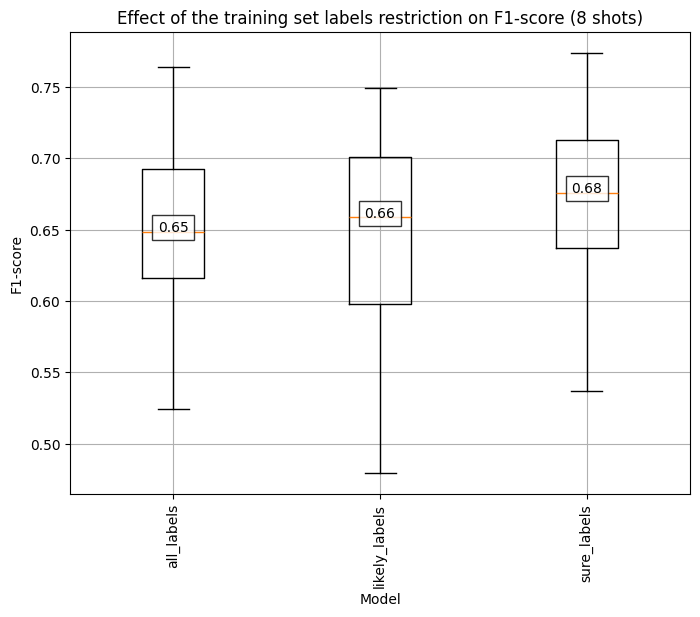

In [32]:
# results, run_times = load_all_results_data(r'../results/setfit/n_shot', "n_shot")
# create_boxplot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/input_length', "input_length_range", {"input_length_range":[[0,2],[1,3],[0,3],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10]]})
# create_boxplot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/language', "lang", {"model":"sentence-transformers/paraphrase-multilingual-mpnet-base-v2", "n_shot":8})
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets) (multilingual model) (8 shots)', 'Language', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/language', "lang", {"model":"sentence-transformers/paraphrase-mpnet-base-v2", "n_shot":8})
# create_boxplot(results, 'Effect of the language on F1-score (train and test sets) (not multilingual model) (8 shots)', 'Language', 'F1-score')

# results, run_times = load_all_results_data(r'../results/setfit/model', "model", {"n_shot":8})
# create_boxplot(results, 'Effect of the model on F1-score (8 shots)', 'Model', 'F1-score', vertical_xticks=True)

# for strategy in ["back_translation", "synonym_replacement", "crossover", "swapping_inter"]:
# 	results, run_times = load_all_results_data(r'../results/setfit/data_augmentation', "data_augmentation_ratio", {"data_augmentation_strategy":strategy})
# 	create_boxplot(results, f"Effect of the data augmentation ratio on F1-score (8 shots) (strategy: {strategy})", 'Data augmentation ratio', 'F1-score')

# for i in [0.1,0.3,0.5,0.8,1]:
# 	results, run_times = load_all_results_data(r'../results/setfit/data_augmentation', "data_augmentation_ratio", {"data_augmentation_strategy":"synonym_replacement", "strategy_params":{"modification_rate":i}})
# 	create_boxplot(results, f"Effect of the data augmentation ratio (with synonyms) on F1-score (8 shots) (modification_ratio: {i})", 'Data augmentation ratio', 'F1-score')

results, run_times = load_all_results_data(r'../results/setfit/training_set_labels_restriction', "model")
create_boxplot(results, 'Effect of the training set labels restriction on F1-score (8 shots)', 'Model', 'F1-score', vertical_xticks=True)